In [1]:
import os
import sys
import tarfile
import sklearn
import urllib.request
import pandas as pd

# For suppressing a false warning for "chaining" 
pd.options.mode.chained_assignment = None  

assert sys.version_info >= (3, 5)
assert sklearn.__version__ >= "0.20"

# URLs for the zip files
URLs = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
	'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
	'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
	'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
	'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
	'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
	'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
	'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]

DATAPATH = os.path.join("Datasets", "ChestX-ray14", "")
IMG_DIR = os.path.join(DATAPATH, 'images')
os.makedirs(DATAPATH, exist_ok=True)

# Downloads and extracts the zip files
def fetch_data(urls, path):
  
  # Downloads files
    for idx, URL in enumerate(URLs):
        filename = 'images_%02d.tar.gz' % (idx+1)
        print('Downloading ' + filename + '...')
        urllib.request.urlretrieve(URL, DATAPATH + filename)  

    print("Download complete.")

    # Gets file names and sort
    file_names = os.listdir(DATAPATH)
    file_names.sort()

    # Unzips the tar.gz files
    for file_name in file_names:
        file_path = os.path.join(DATAPATH, file_name)
        if file_name.endswith(".gz"):
          file = tarfile.open(file_path)
          file.extractall(path=DATAPATH) 
          file.close()
          # Delete the extracted zip file to free up disk space
          os.remove(os.path.join(DATAPATH, file_name))
          print("File " + file_name + " was deleted")

#fetch_data(URLs, DATAPATH)

# Data exploration and preprocessing

In [2]:
# Print the number of all images for confirmation
file_names = os.listdir(IMG_DIR)
file_names.sort()
print(len(file_names))

112120


In [3]:
# Fetches the metadata

bucket_path = 'gs://ffs-1'
csv_file = "Data_Entry_2017_v2020.csv"
df = pd.read_csv(os.path.join(bucket_path, csv_file))

df.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_001.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           57              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           80              M            PA                 2500     2048   
4           74              F            PA                 2500     2048   

   OriginalImagePixelSpacing[x     y]  
0                        0.143  0.143  
1                        0.143  0.143  
2                        0.168  0.168  
3                        0.171  0.171  
4                        0.168  0.168

In [4]:
import numpy as np
np.random.seed(42)
from itertools import chain

# Extracts labels from a dataframe
def extract_labels(dataframe):
    # Replacing 'No Finding' finding labels by an empty string
    dataframe.loc[:,'Finding Labels'] = dataframe.loc[:,'Finding Labels'].map(lambda x: x.replace('No Finding', ''))
    # Splits each value of the 'Finding Labels' column by |, then convert the resulting Series to a list
    # Chain the elements of the Series together, then convert to a list
    # Finally, extract a sublist consisting of only unique values
    series = dataframe.loc[:,'Finding Labels'].map(lambda x: x.split('|'))
    list1 = series.tolist()
    chain1 = chain(*list1)
    list2 = list(chain1)
    labels = np.unique(list2)
    
    # Removes the empty label
    labels = [x for x in labels if len(x) > 0]
    return labels
    
labels = extract_labels(df)
print(labels)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [5]:
# Drops rows where the Finding Label is empty
df = df[df['Finding Labels'] != '']
# Sets Image Index column as index
df.set_index('Image Index', inplace=True)
df.shape

(51759, 10)

In [6]:
# Number of unique patients in the dataset after the removal of 'No Finding' rows.
unique_patients = df['Patient ID'].unique()
print(len(unique_patients))

14402


In [7]:
# Dictionary for pathology: occurence from the entire dataset
label_counts = dict()

# Counts pathology occurences in dataframe from labels 
def count_occurences(labels, dataframe):
    counts = dict()
    for label in labels:
        count = 0
        for i in dataframe.index:
            if(label in dataframe.loc[i, "Finding Labels"]):
                count += 1
                counts[label] = count
    return counts

label_counts = count_occurences(labels, df)
print(label_counts)

{'Atelectasis': 11559, 'Cardiomegaly': 2776, 'Consolidation': 4667, 'Edema': 2303, 'Effusion': 13317, 'Emphysema': 2516, 'Fibrosis': 1686, 'Hernia': 227, 'Infiltration': 19894, 'Mass': 5782, 'Nodule': 6331, 'Pleural_Thickening': 3385, 'Pneumonia': 1431, 'Pneumothorax': 5302}


Saving figure Pathology distribution of the entire dataset


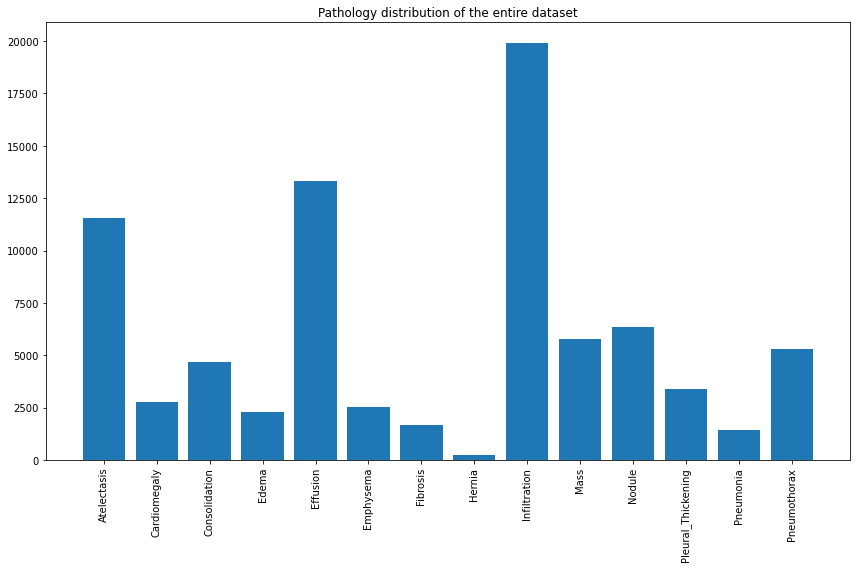

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

SAVED_IMAGES = os.path.join('.', "Saved images")
os.makedirs(SAVED_IMAGES, exist_ok=True)

# Plots the pathology distribution
def plot_bar_chart(pathology_counts, title):
    f, ax = plt.subplots(figsize=(12, 8))
    ax.bar(range(len(pathology_counts)), list(pathology_counts.values()))
    plt.xticks(range(len(pathology_counts)), list(pathology_counts.keys()), rotation=90)
    ax.set_title(title)

# Saves an image
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(SAVED_IMAGES, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
img_title = 'Pathology distribution of the entire dataset'
plot_bar_chart(label_counts, img_title)
save_fig(img_title)
plt.show()

In [9]:
# Fetches train_val.csv and test.csv
train_val_csv = "train_val.csv"
test_csv = "test.csv"

train_val_df = pd.read_csv(os.path.join(bucket_path, train_val_csv))
test_df = pd.read_csv(os.path.join(bucket_path, test_csv))

print('train_val_df:',train_val_df.shape, 'test_df:', test_df.shape)

train_val_df: (86524, 1) test_df: (25596, 1)


In [10]:
train_val_df.head()

Image Index
0  00000001_000.png
1  00000001_001.png
2  00000001_002.png
3  00000002_000.png
4  00000004_000.png

In [11]:
test_df.head()

Image Index
0  00000003_000.png
1  00000003_001.png
2  00000003_002.png
3  00000003_003.png
4  00000003_004.png

In [12]:
#from glob import glob

#all_image_paths = {os.path.basename(x): x for x in 
#                   glob(os.path.join('.', DATAPATH, 'images*', '*.png'))}

#print('Scans found:', len(all_image_paths), ', Total Headers', train_val_df.shape[0])

In [13]:
#values_view = all_image_paths.values()
#value_iterator = iter(values_view)
#first_value = next(value_iterator)

#print(first_value)

In [14]:
# Adds an Image Name column to a dataframe
def add_img_name(dataframe):
    dataframe['Image Name'] = dataframe['Image Index'].map(lambda x: x)

In [15]:
add_img_name(train_val_df)
add_img_name(test_df)

train_val_df.head()

Image Index        Image Name
0  00000001_000.png  00000001_000.png
1  00000001_001.png  00000001_001.png
2  00000001_002.png  00000001_002.png
3  00000002_000.png  00000002_000.png
4  00000004_000.png  00000004_000.png

In [16]:
# Sets the Image Index column as the index
test_df.set_index('Image Index', inplace=True)
train_val_df.set_index('Image Index', inplace=True)

train_val_df.head()

Image Name
Image Index                       
00000001_000.png  00000001_000.png
00000001_001.png  00000001_001.png
00000001_002.png  00000001_002.png
00000002_000.png  00000002_000.png
00000004_000.png  00000004_000.png

In [17]:
test_df.head()

Image Name
Image Index                       
00000003_000.png  00000003_000.png
00000003_001.png  00000003_001.png
00000003_002.png  00000003_002.png
00000003_003.png  00000003_003.png
00000003_004.png  00000003_004.png

In [18]:
#train_val_df['path'] = train_val_df['Image Name'].map(all_image_paths.get)
#test_df['path'] = test_df['Image Name'].map(all_image_paths.get)

In [19]:
train_val_df.head()

Image Name
Image Index                       
00000001_000.png  00000001_000.png
00000001_001.png  00000001_001.png
00000001_002.png  00000001_002.png
00000002_000.png  00000002_000.png
00000004_000.png  00000004_000.png

In [20]:
test_df.head()

Image Name
Image Index                       
00000003_000.png  00000003_000.png
00000003_001.png  00000003_001.png
00000003_002.png  00000003_002.png
00000003_003.png  00000003_003.png
00000003_004.png  00000003_004.png

In [21]:
# Checks for a patient overlap between 2 subsets
def check_overlap(df1, df2):
    patients1 = df1.index.map(lambda x: x.split('_')[0]) 
    patients2 = df2.index.map(lambda x: x.split('_')[0])
    return list(set(patients1) & set(patients2))

In [22]:
# Checking whether the official split: train_val and test are indeed patient-wise
overlap = check_overlap(train_val_df, test_df)
print('Number of patients in both subsets', len(overlap))

Number of patients in both subsets 0


In [23]:
# Drops instances from the df1 set that are not in the df2 set
def drop_differences(df1, df2):
    df2.drop(df2.iloc[:, 6:11], inplace = True, axis = 1)
    df3 = df1[df1.index.isin(df2.index)]
    return df3

# Drops instances from the train_val and test sets that has 'No Finding' labels.
train_val_df = drop_differences(train_val_df, df)
test_df = drop_differences(test_df, df)
print('train_val_df:',train_val_df.shape, 'test_df:', test_df.shape)

train_val_df: (36024, 1) test_df: (15735, 1)


In [24]:
# Adds 'Finding Labels' column to df1 if the Image Index matches with instances in df2
train_val_df = train_val_df.merge(df, left_index = True, right_index = True)
test_df = test_df.merge(df, left_index = True, right_index = True)

print('train_val_df:',train_val_df.shape, 'test_df:', test_df.shape)

train_val_df: (36024, 7) test_df: (15735, 7)


In [25]:
# Dictionary for pathology: occurence from the train_val set
train_val_label_counts = dict()
train_val_label_counts = count_occurences(labels, train_val_df)
print('Training and validation set label counts:', train_val_label_counts)

Training and validation set label counts: {'Atelectasis': 8280, 'Cardiomegaly': 1707, 'Consolidation': 2852, 'Edema': 1378, 'Effusion': 8659, 'Emphysema': 1423, 'Fibrosis': 1251, 'Hernia': 141, 'Infiltration': 13782, 'Mass': 4034, 'Nodule': 4708, 'Pleural_Thickening': 2242, 'Pneumonia': 876, 'Pneumothorax': 2637}


In [26]:
# Dictionary for pathology: occurence from the test set
test_label_counts = dict()
test_label_counts = count_occurences(labels, test_df)
print('Test set label counts:', test_label_counts)

Test set label counts: {'Atelectasis': 3279, 'Cardiomegaly': 1069, 'Consolidation': 1815, 'Edema': 925, 'Effusion': 4658, 'Emphysema': 1093, 'Fibrosis': 435, 'Hernia': 86, 'Infiltration': 6112, 'Mass': 1748, 'Nodule': 1623, 'Pleural_Thickening': 1143, 'Pneumonia': 555, 'Pneumothorax': 2665}


Saving figure Pathology distribution of train_val and test splits


<Figure size 432x288 with 0 Axes>

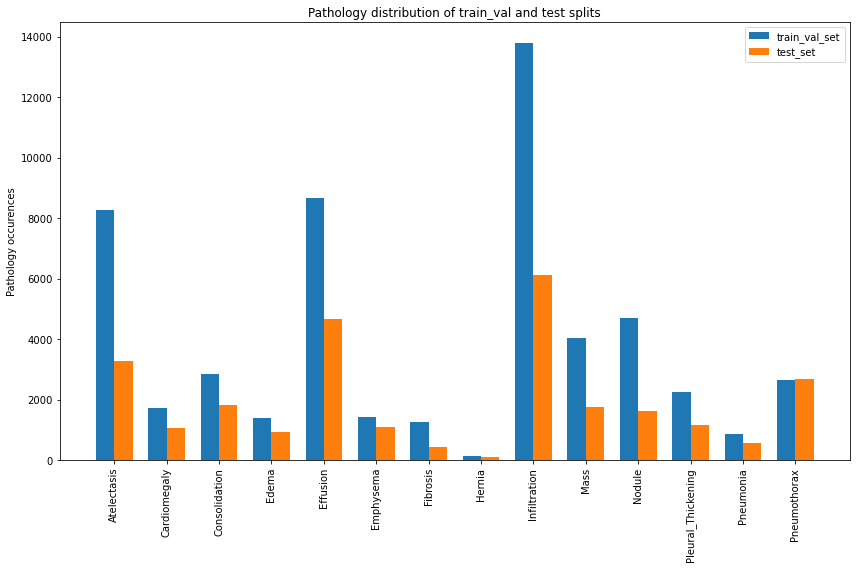

In [27]:
def plot_grouped_bar_chart(counts1, counts2, title, label1, label2):
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(12, 8))
    rects1 = ax.bar(x - width/2, counts1, width, label=label1)
    rects2 = ax.bar(x + width/2, counts2, width, label=label2)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Pathology occurences')
    ax.set_title('Pathology distribution of train_val and test splits')
    ax.set_xticks(x)
    ax.set_xticklabels(labels,rotation=90)
    ax.legend()

    fig.tight_layout()
    plt.show()
    
img_title = 'Pathology distribution of train_val and test splits'
save_fig(img_title)
plot_grouped_bar_chart(train_val_label_counts.values(), test_label_counts.values(), img_title, 'train_val_set', 'test_set')

In [28]:
# Calculates the proportion of label distribution
def label_proportion(label_counts):
    counts = list(label_counts.values())
    proportions = list(map(lambda x: x/sum(counts), counts))
    return proportions    

In [29]:
# Shows the comparison of label proporion in 2 or more splits
compare_propotions = pd.DataFrame({
    "Pathology": label_counts.keys(),
    "Entire dataset": label_proportion(label_counts),
    "Training and validation split": label_proportion(train_val_label_counts),
    "Test split": label_proportion(test_label_counts)
})
compare_propotions["Training and validation split error %"] = 100 * compare_propotions["Training and validation split"]/ compare_propotions["Entire dataset"] - 100
compare_propotions["Test split error %"] = 100 * compare_propotions["Test split"]/ compare_propotions["Entire dataset"] - 100

compare_propotions

Pathology  Entire dataset  Training and validation split  \
0          Atelectasis        0.142394                       0.153419   
1         Cardiomegaly        0.034197                       0.031629   
2        Consolidation        0.057492                       0.052844   
3                Edema        0.028370                       0.025533   
4             Effusion        0.164051                       0.160441   
5            Emphysema        0.030994                       0.026366   
6             Fibrosis        0.020770                       0.023180   
7               Hernia        0.002796                       0.002613   
8         Infiltration        0.245072                       0.255364   
9                 Mass        0.071228                       0.074745   
10              Nodule        0.077991                       0.087234   
11  Pleural_Thickening        0.041700                       0.041542   
12           Pneumonia        0.017628                       0.016231   
13        Pneumothorax        0.065315                       0.048860   

    Test split  Training and validation split error %  Test split error %  
0     0.120525                               7.742067          -15.358353  
1     0.039293                              -7.511169           14.900309  
2     0.066713                              -8.084882           16.038413  
3     0.034000                             -10.002487           19.842469  
4     0.171212                              -2.200515            4.365279  
5     0.040175                             -14.931359           29.620138  
6     0.015989                              11.602769          -23.017034  
7     0.003161                              -6.573843           13.040885  
8     0.224656                               4.199434           -8.330643  
9     0.064251                               4.938061           -9.795896  
10    0.059656                              11.850871          -23.509208  
11    0.042013                              -0.378709            0.751266  
12    0.020400                              -7.925429           15.722099  
13    0.097956                             -25.192415           49.975543

In [30]:
# Adds 14 columns to a dataframe corresponding to each pathology where the values can be either 1 or 0, 
# indicating the presence or absence of the pathology the column represents
def add_pathology_columns(dataframe, labels):
    for label in labels:
        dataframe[label] = dataframe['Finding Labels'].map(lambda finding: 1 if label in finding else 0)

In [31]:
# Adds pathology columns to the train_val and test splits
add_pathology_columns(train_val_df, labels)
add_pathology_columns(test_df, labels)

print('training', train_val_df.shape, 'validation', test_df.shape)

training (36024, 21) validation (15735, 21)


In [32]:
train_val_df.head()

Image Name          Finding Labels  Follow-up #  \
Image Index                                                               
00000001_000.png  00000001_000.png            Cardiomegaly            0   
00000001_001.png  00000001_001.png  Cardiomegaly|Emphysema            1   
00000001_002.png  00000001_002.png   Cardiomegaly|Effusion            2   
00000004_000.png  00000004_000.png             Mass|Nodule            0   
00000005_006.png  00000005_006.png            Infiltration            6   

                  Patient ID  Patient Age Patient Gender View Position  \
Image Index                                                              
00000001_000.png           1           57              M            PA   
00000001_001.png           1           58              M            PA   
00000001_002.png           1           58              M            PA   
00000004_000.png           4           82              M            AP   
00000005_006.png           5           70              F            PA   

                  Atelectasis  Cardiomegaly  Consolidation  ...  Effusion  \
Image Index                                                 ...             
00000001_000.png            0             1              0  ...         0   
00000001_001.png            0             1              0  ...         0   
00000001_002.png            0             1              0  ...         1   
00000004_000.png            0             0              0  ...         0   
00000005_006.png            0             0              0  ...         0   

                  Emphysema  Fibrosis  Hernia  Infiltration  Mass  Nodule  \
Image Index                                                                 
00000001_000.png          0         0       0             0     0       0   
00000001_001.png          1         0       0             0     0       0   
00000001_002.png          0         0       0             0     0       0   
00000004_000.png          0         0       0             0     1       1   
00000005_006.png          0         0       0             1     0       0   

                  Pleural_Thickening  Pneumonia  Pneumothorax  
Image Index                                                    
00000001_000.png                   0          0             0  
00000001_001.png                   0          0             0  
00000001_002.png                   0          0             0  
00000004_000.png                   0          0             0  
00000005_006.png                   0          0             0  

[5 rows x 21 columns]

In [33]:
train_val_df['Label Vector'] = train_val_df.apply(lambda x: [x[labels].values], 1).map(lambda x: x[0])
test_df['Label Vector'] = test_df.apply(lambda x: [x[labels].values], 1).map(lambda x: x[0])
#def add_pathology_vector(dataframe):
#    dataframe['Label Vector'] = []
#    for label in labels:
#         dataframe['Label Vector'].append(dataframe['Finding Labels'].map(lambda finding: 1 if label in finding else 0))

In [34]:
train_val_df.head()

Image Name          Finding Labels  Follow-up #  \
Image Index                                                               
00000001_000.png  00000001_000.png            Cardiomegaly            0   
00000001_001.png  00000001_001.png  Cardiomegaly|Emphysema            1   
00000001_002.png  00000001_002.png   Cardiomegaly|Effusion            2   
00000004_000.png  00000004_000.png             Mass|Nodule            0   
00000005_006.png  00000005_006.png            Infiltration            6   

                  Patient ID  Patient Age Patient Gender View Position  \
Image Index                                                              
00000001_000.png           1           57              M            PA   
00000001_001.png           1           58              M            PA   
00000001_002.png           1           58              M            PA   
00000004_000.png           4           82              M            AP   
00000005_006.png           5           70              F            PA   

                  Atelectasis  Cardiomegaly  Consolidation  ...  Emphysema  \
Image Index                                                 ...              
00000001_000.png            0             1              0  ...          0   
00000001_001.png            0             1              0  ...          1   
00000001_002.png            0             1              0  ...          0   
00000004_000.png            0             0              0  ...          0   
00000005_006.png            0             0              0  ...          0   

                  Fibrosis  Hernia  Infiltration  Mass  Nodule  \
Image Index                                                      
00000001_000.png         0       0             0     0       0   
00000001_001.png         0       0             0     0       0   
00000001_002.png         0       0             0     0       0   
00000004_000.png         0       0             0     1       1   
00000005_006.png         0       0             1     0       0   

                  Pleural_Thickening  Pneumonia  Pneumothorax  \
Image Index                                                     
00000001_000.png                   0          0             0   
00000001_001.png                   0          0             0   
00000001_002.png                   0          0             0   
00000004_000.png                   0          0             0   
00000005_006.png                   0          0             0   

                                                Label Vector  
Image Index                                                   
00000001_000.png  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
00000001_001.png  [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]  
00000001_002.png  [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
00000004_000.png  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]  
00000005_006.png  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  

[5 rows x 22 columns]

In [35]:
from sklearn.model_selection import train_test_split

# Stratified label-wise split of the train_val set with a 4:1 ratio. 
train_df, valid_df = train_test_split(train_val_df, test_size = 0.2, random_state = 42, 
                                      stratify = train_val_df['Finding Labels'].map(lambda x: x.split('|')[0]))

print('Training split by label', train_df.shape, 'Validation split by label', valid_df.shape)

Training split by label (28819, 22) Validation split by label (7205, 22)


In [36]:
train_df.head()

Image Name  \
Image Index                          
00018447_000.png  00018447_000.png   
00020826_011.png  00020826_011.png   
00016266_002.png  00016266_002.png   
00019916_000.png  00019916_000.png   
00010456_009.png  00010456_009.png   

                                                     Finding Labels  \
Image Index                                                           
00018447_000.png                                               Mass   
00020826_011.png  Atelectasis|Consolidation|Edema|Effusion|Infil...   
00016266_002.png                              Fibrosis|Pneumothorax   
00019916_000.png                                       Infiltration   
00010456_009.png                                           Effusion   

                  Follow-up #  Patient ID  Patient Age Patient Gender  \
Image Index                                                             
00018447_000.png            0       18447           69              F   
00020826_011.png           10       20826           22              M   
00016266_002.png            2       16266           56              F   
00019916_000.png            0       19916           54              F   
00010456_009.png            8       10456           28              M   

                 View Position  Atelectasis  Cardiomegaly  Consolidation  ...  \
Image Index                                                               ...   
00018447_000.png            PA            0             0              0  ...   
00020826_011.png            AP            1             0              1  ...   
00016266_002.png            PA            0             0              0  ...   
00019916_000.png            PA            0             0              0  ...   
00010456_009.png            AP            0             0              0  ...   

                  Emphysema  Fibrosis  Hernia  Infiltration  Mass  Nodule  \
Image Index                                                                 
00018447_000.png          0         0       0             0     1       0   
00020826_011.png          0         0       0             1     0       0   
00016266_002.png          0         1       0             0     0       0   
00019916_000.png          0         0       0             1     0       0   
00010456_009.png          0         0       0             0     0       0   

                  Pleural_Thickening  Pneumonia  Pneumothorax  \
Image Index                                                     
00018447_000.png                   0          0             0   
00020826_011.png                   0          0             0   
00016266_002.png                   0          0             1   
00019916_000.png                   0          0             0   
00010456_009.png                   0          0             0   

                                                Label Vector  
Image Index                                                   
00018447_000.png  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]  
00020826_011.png  [1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]  
00016266_002.png  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]  
00019916_000.png  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  
00010456_009.png  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  

[5 rows x 22 columns]

In [37]:
#train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
#valid_df['newLabel'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
#test_df['newLabel'] = test_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

In [38]:
# Calculating label counts for training and validation splits
train_label_counts = count_occurences(labels, train_df)
valid_label_counts = count_occurences(labels, valid_df)

print('Training set label counts:', train_label_counts)

Training set label counts: {'Atelectasis': 6624, 'Cardiomegaly': 1362, 'Consolidation': 2287, 'Edema': 1104, 'Effusion': 6917, 'Emphysema': 1154, 'Fibrosis': 1013, 'Hernia': 118, 'Infiltration': 11037, 'Mass': 3255, 'Nodule': 3737, 'Pleural_Thickening': 1797, 'Pneumonia': 702, 'Pneumothorax': 2106}


In [39]:
print('Validation set label counts:', valid_label_counts)

Validation set label counts: {'Atelectasis': 1656, 'Cardiomegaly': 345, 'Consolidation': 565, 'Edema': 274, 'Effusion': 1742, 'Emphysema': 269, 'Fibrosis': 238, 'Hernia': 23, 'Infiltration': 2745, 'Mass': 779, 'Nodule': 971, 'Pleural_Thickening': 445, 'Pneumonia': 174, 'Pneumothorax': 531}


Saving figure Pathology distribution of training and validation splits


<Figure size 432x288 with 0 Axes>

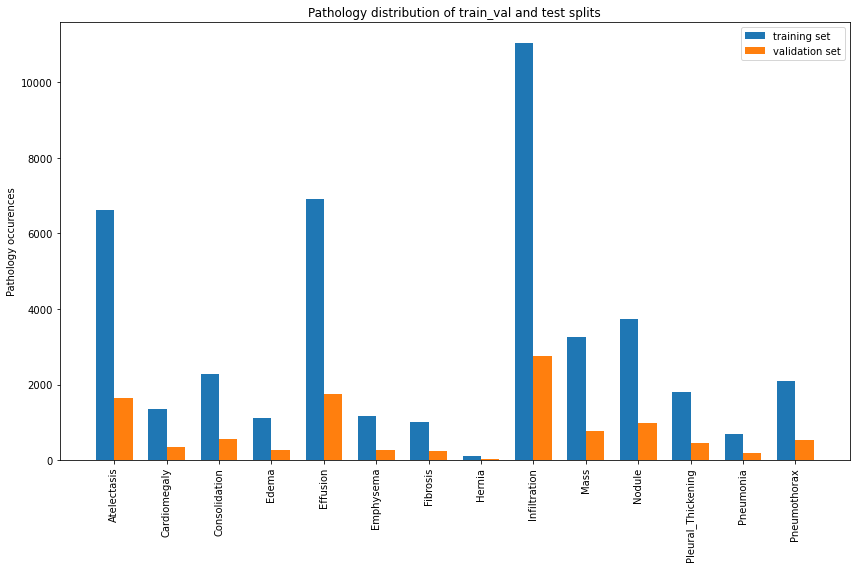

In [40]:
img_title = 'Pathology distribution of training and validation splits'
save_fig(img_title)
plot_grouped_bar_chart(train_label_counts.values(), valid_label_counts.values(), img_title, 
                                                           'training set', 'validation set')

In [41]:
# Comparing the label proportion of label-wise training and validation splits
compare_propotions = pd.DataFrame({
    "Pathology": label_counts.keys(),
    "Training and validation split": label_proportion(train_val_label_counts),
    "Training split by label": label_proportion(train_label_counts),
    "Validation split by label": label_proportion(valid_label_counts)
})
compare_propotions["Training split by label-error %"] = 100 * compare_propotions["Training split by label"]/ compare_propotions["Training and validation split"] - 100
compare_propotions["Validation split by label-error %"] = 100 * compare_propotions["Validation split by label"]/ compare_propotions["Training and validation split"] - 100

compare_propotions

Pathology  Training and validation split  \
0          Atelectasis                       0.153419   
1         Cardiomegaly                       0.031629   
2        Consolidation                       0.052844   
3                Edema                       0.025533   
4             Effusion                       0.160441   
5            Emphysema                       0.026366   
6             Fibrosis                       0.023180   
7               Hernia                       0.002613   
8         Infiltration                       0.255364   
9                 Mass                       0.074745   
10              Nodule                       0.087234   
11  Pleural_Thickening                       0.041542   
12           Pneumonia                       0.016231   
13        Pneumothorax                       0.048860   

    Training split by label  Validation split by label  \
0                  0.153287                   0.153946   
1                  0.031518                   0.032072   
2                  0.052924                   0.052524   
3                  0.025548                   0.025472   
4                  0.160068                   0.161941   
5                  0.026705                   0.025007   
6                  0.023442                   0.022125   
7                  0.002731                   0.002138   
8                  0.255409                   0.255183   
9                  0.075325                   0.072418   
10                 0.086479                   0.090267   
11                 0.041585                   0.041368   
12                 0.016245                   0.016176   
13                 0.048735                   0.049363   

    Training split by label-error %  Validation split by label-error %  
0                         -0.085622                           0.343962  
1                         -0.349017                           1.402071  
2                          0.150851                          -0.605998  
3                          0.059391                          -0.238586  
4                         -0.232742                           0.934971  
5                          1.283549                          -5.156269  
6                          1.132359                          -4.548909  
7                          4.520360                         -18.159180  
8                          0.017685                          -0.071043  
9                          0.775068                          -3.113601  
10                        -0.865540                           3.477047  
11                         0.103778                          -0.416898  
12                         0.085464                          -0.343325  
13                        -0.256125                           1.028904

In [42]:
# Convert the values in 'Finding Labels' column if the datatype is not list
train_df['Finding Labels'] = train_df['Finding Labels'].map(lambda x: x if isinstance(x, list) else x.split('|'))
valid_df['Finding Labels'] = valid_df['Finding Labels'].map(lambda x: x if isinstance(x, list) else x.split('|'))
test_df['Finding Labels'] = test_df['Finding Labels'].map(lambda x: x if isinstance(x, list) else x.split('|'))

In [43]:
train_df.head()

Image Name  \
Image Index                          
00018447_000.png  00018447_000.png   
00020826_011.png  00020826_011.png   
00016266_002.png  00016266_002.png   
00019916_000.png  00019916_000.png   
00010456_009.png  00010456_009.png   

                                                     Finding Labels  \
Image Index                                                           
00018447_000.png                                             [Mass]   
00020826_011.png  [Atelectasis, Consolidation, Edema, Effusion, ...   
00016266_002.png                           [Fibrosis, Pneumothorax]   
00019916_000.png                                     [Infiltration]   
00010456_009.png                                         [Effusion]   

                  Follow-up #  Patient ID  Patient Age Patient Gender  \
Image Index                                                             
00018447_000.png            0       18447           69              F   
00020826_011.png           10       20826           22              M   
00016266_002.png            2       16266           56              F   
00019916_000.png            0       19916           54              F   
00010456_009.png            8       10456           28              M   

                 View Position  Atelectasis  Cardiomegaly  Consolidation  ...  \
Image Index                                                               ...   
00018447_000.png            PA            0             0              0  ...   
00020826_011.png            AP            1             0              1  ...   
00016266_002.png            PA            0             0              0  ...   
00019916_000.png            PA            0             0              0  ...   
00010456_009.png            AP            0             0              0  ...   

                  Emphysema  Fibrosis  Hernia  Infiltration  Mass  Nodule  \
Image Index                                                                 
00018447_000.png          0         0       0             0     1       0   
00020826_011.png          0         0       0             1     0       0   
00016266_002.png          0         1       0             0     0       0   
00019916_000.png          0         0       0             1     0       0   
00010456_009.png          0         0       0             0     0       0   

                  Pleural_Thickening  Pneumonia  Pneumothorax  \
Image Index                                                     
00018447_000.png                   0          0             0   
00020826_011.png                   0          0             0   
00016266_002.png                   0          0             1   
00019916_000.png                   0          0             0   
00010456_009.png                   0          0             0   

                                                Label Vector  
Image Index                                                   
00018447_000.png  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]  
00020826_011.png  [1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]  
00016266_002.png  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]  
00019916_000.png  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  
00010456_009.png  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  

[5 rows x 22 columns]

# Model Training

In [44]:
#from keras.preprocessing.image import load_img
#from keras.preprocessing.image import save_img
#from keras.preprocessing.image import img_to_array

IMG_SIZE = (224, 224)

#def get_data(img_dir, dataframe):
#  images = []
#  image_labels = []
#  for row in range(len(dataframe)):
#      image_name = dataframe['Image Name'].iloc[row]
#      image = load_img(os.path.join(img_dir, image_name))
#      image = image.resize(IMG_SIZE)
#      image_array = img_to_array(image)
#      images.append(image_array)
#  images = np.array(images)
#  image_labels = np.array(image_labels)
#  return images

Using TensorFlow backend.


In [45]:
#trainX = get_data(IMG_DIR, train_df)
#print('trainX shape: ', trainX.shape)

In [46]:
import gc
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

#resnet_preprocessor = keras.applications.resnet50.preprocess_input

# Setting up an image data generator
idg = ImageDataGenerator(samplewise_center=True, 
                         samplewise_std_normalization=True)

# Calculating statistics on the training subset
#idg.fit(trainX)
# trainX takes up 16.2GB memory, thus:
#del trainX # deleting trainX
#gc.collect() # running garbage collector

In [47]:
# Setting up iterators for each subset

train_iter = idg.flow_from_dataframe(dataframe=train_df, 
                             directory = IMG_DIR,
                             x_col = 'Image Name',
                            y_col = 'Finding Labels', 
                             class_mode = 'categorical',
                            classes = labels,
                            color_mode = 'grayscale',
                            target_size = IMG_SIZE,
                            batch_size = 32)

valid_iter = idg.flow_from_dataframe(dataframe=valid_df, 
                             directory = IMG_DIR,
                             x_col = 'Image Name',
                            y_col = 'Finding Labels', 
                             class_mode = 'categorical',
                            classes = labels,
                            color_mode = 'grayscale',
                            target_size = IMG_SIZE,
                            batch_size = 32)

test_iter = idg.flow_from_dataframe(dataframe=test_df, 
                             directory = IMG_DIR,
                             x_col = 'Image Name',
                            y_col = 'Finding Labels', 
                             class_mode = 'categorical',
                            classes = labels,
                            color_mode = 'grayscale',
                            target_size = IMG_SIZE,
                            batch_size = 15735)

# Get next batches
train_X, train_Y = train_iter.next()
valid_X, valid_Y = valid_iter.next()
test_X, test_Y = test_iter.next()

print('Batches train=%d, validation=%d, test=%d' % (len(train_iter), len(valid_iter),len(test_iter)))
print('Batch X shape=%s, min=%.3f, max=%.3f' % (train_X.shape, train_X.min(), train_X.max()))
print('Batch Y shape=%s, min=%.3f, max=%.3f' % (train_Y.shape, train_Y.min(), train_Y.max()))

Found 28819 validated image filenames belonging to 14 classes.
Found 7205 validated image filenames belonging to 14 classes.
Found 15735 validated image filenames belonging to 14 classes.
Batches train=901, validation=226, test=1
Batch X shape=(32, 224, 224, 1), min=-3.670, max=3.049
Batch Y shape=(32, 14), min=0.000, max=1.000


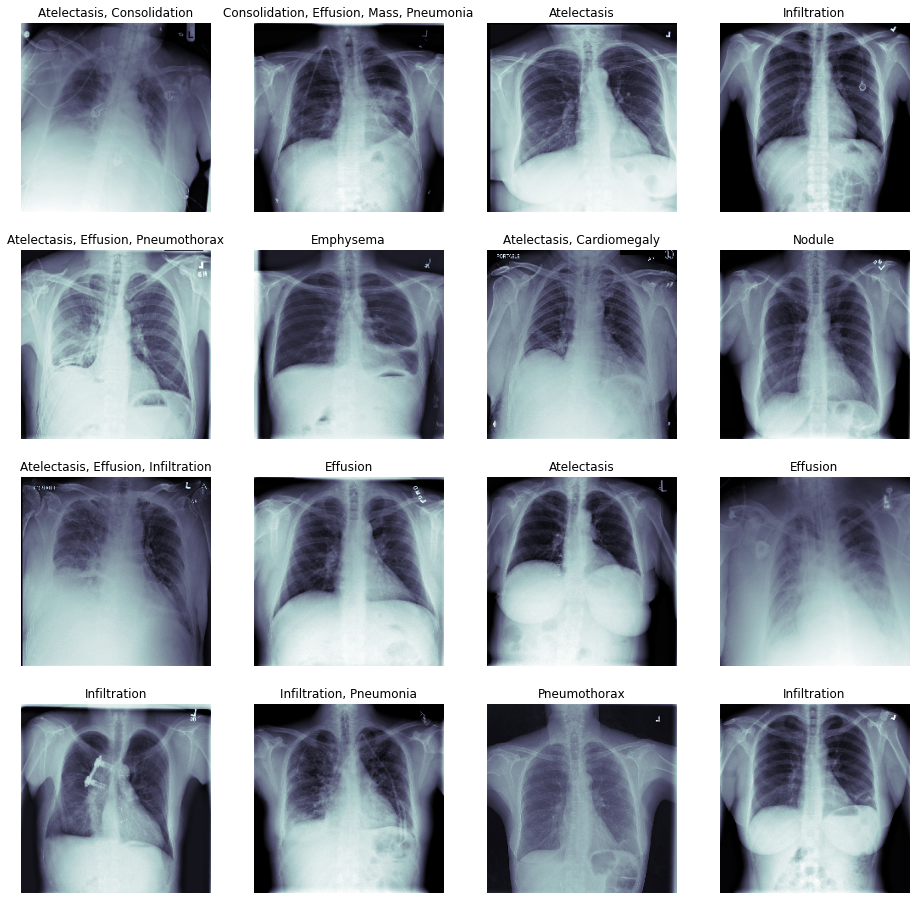

In [48]:
t_x, t_y = train_iter.next()
fig, axs = plt.subplots(4, 4, figsize = (16, 16))

# Displaying positive examples of augmented images from the training subset
for (x, y, ax) in zip(t_x, t_y, axs.flatten()):
    ax.imshow(x[:,:, 0], cmap = 'bone')
    ax.set_title(', '.join([label for label, score in zip(labels, y) if score > 0.5]))
    ax.axis('off')

In [49]:
t_x.shape[1:]

(224, 224, 1)

In [50]:
print(t_y[3])

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [51]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.applications.resnet import ResNet50
from keras.applications.mobilenet import MobileNet

assert tf.__version__ >= "2.0"
tf.random.set_seed(42)

def create_resnet50():
    base_resnet50 = ResNet50(input_shape = t_x.shape[1:], include_top = False, weights = None)
    model = Sequential()
    model.add(base_resnet50)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(224))
    model.add(Dropout(0.5))
    model.add(Dense(len(labels), activation = 'sigmoid'))
    return model

def create_mobilenet():
    base_resnet50 = MobileNet(input_shape = t_x.shape[1:], include_top = False, weights = None)
    model = Sequential()
    model.add(base_resnet50)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(224))
    model.add(Dropout(0.5))
    model.add(Dense(len(labels), activation = 'sigmoid'))
    return model

In [52]:
# Calculating class weights to adjust the binary cross-entropy (BCE) loss function
# Adjusting the BCE loss function with class weights is preferable for datasets with high 
# class-imbalance, in case of multi-label classification task.

class_weights = dict()
class_num = 0

for key in train_label_counts.keys():
    class_weights[class_num] = 1 - train_label_counts[key]/sum(train_label_counts.values())
    class_num = class_num + 1
    
print(class_weights)

{0: 0.8467127947608358, 1: 0.9684817068937588, 2: 0.9470761113553792, 3: 0.9744521324601393, 4: 0.8399324277416518, 5: 0.9732950732418485, 6: 0.9765579802374286, 7: 0.9972693402448337, 8: 0.7445907481544906, 9: 0.9246754448892694, 10: 0.9135213940249463, 11: 0.9584152916946289, 12: 0.9837548885751973, 13: 0.9512646657255919}


In [53]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import optimizers, callbacks, regularizers

resnet_weight_path="resnet50_best_weights.hdf5"
mobilenet_weight_path="mobilenet_best_weights.hdf5"

optimizer_list = [('adam', optimizers.Adam())]
checkpoint = ModelCheckpoint(filepath=resnet_weight_path, monitor = 'val_loss', verbose=1, 
                             save_best_only=True, mode = 'min', save_weights_only = True)

early = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5, restore_best_weights=True)
callbacks_list = [checkpoint, early]

## ResNet50

### Using original images

In [55]:
resnet50 = create_resnet50()
resnet50.compile(optimizer='adam', loss = 'binary_crossentropy', 
               metrics = ['binary_accuracy', 'mae'])

resnet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23581440  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 224)               458976    
_________________________________________________________________
dropout_1 (Dropout)          (None, 224)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                3150      
Total params: 24,043,566
Trainable params: 23,990,446
Non-trainable params: 53,120
_______________________________________

In [56]:
history = resnet50.fit(train_iter, steps_per_epoch=len(train_iter), callbacks = callbacks_list,
                epochs = 50, validation_data = valid_iter)

Epoch 1/50
901/901 [==============================] - 498s 545ms/step - loss: 0.4080 - binary_accuracy: 0.8773 - mae: 0.1802 - val_loss: 0.2844 - val_binary_accuracy: 0.8933 - val_mae: 0.1602
Epoch 2/50
901/901 [==============================] - 489s 543ms/step - loss: 0.3016 - binary_accuracy: 0.8900 - mae: 0.1693 - val_loss: 0.3906 - val_binary_accuracy: 0.8769 - val_mae: 0.1677
Epoch 3/50
901/901 [==============================] - 488s 542ms/step - loss: 0.2949 - binary_accuracy: 0.8917 - mae: 0.1676 - val_loss: 0.2973 - val_binary_accuracy: 0.8936 - val_mae: 0.1607
Epoch 4/50
901/901 [==============================] - 490s 543ms/step - loss: 0.2876 - binary_accuracy: 0.8931 - mae: 0.1662 - val_loss: 0.2795 - val_binary_accuracy: 0.8939 - val_mae: 0.1607
Epoch 5/50
901/901 [==============================] - 490s 543ms/step - loss: 0.2870 - binary_accuracy: 0.8927 - mae: 0.1666 - val_loss: 0.2853 - val_binary_accuracy: 0.8939 - val_mae: 0.1836
Epoch 6/50
901/901 [====================

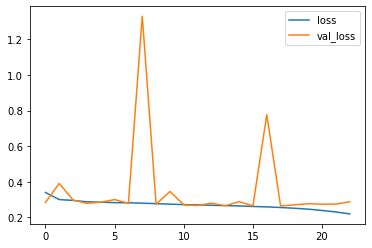

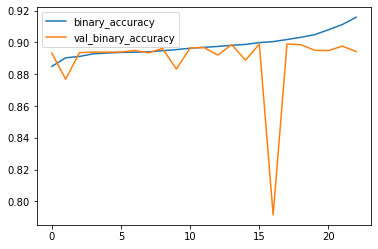

In [57]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [57]:
#resnet50 = create_resnet50()
resnet50.load_weights(resnet_weight_path)

resnet50_preds = resnet50.predict(test_X, verbose = True)

492/492 [==============================] - 58s 112ms/step


In [58]:
from sklearn.metrics import roc_curve, auc

def plot_ROC(labels, test_Y, pred_Y, filename):
    AUC_scores = []
    fig, ax = plt.subplots(1,1, figsize = (9, 9))
    for (idx, label) in enumerate(labels):
        fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
        ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
        AUC_scores.append(auc(fpr,tpr))
    ax.legend()
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    fig.savefig(filename)
    return AUC_scores

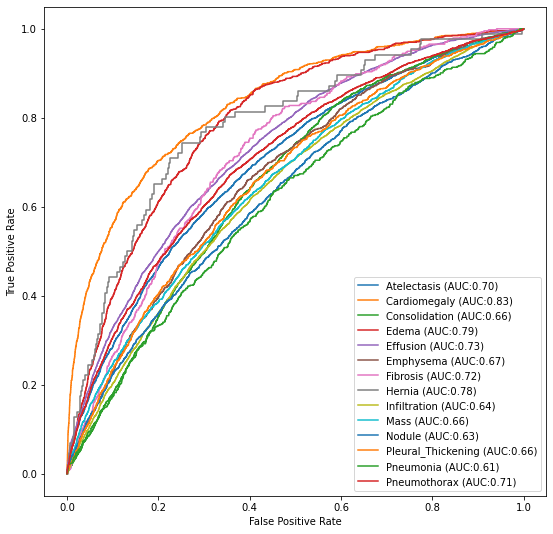

In [59]:
resnet50_AUC = plot_ROC(labels, test_Y, resnet50_preds, filename="resnet50_ROC.png")

### Using augmented images 

In [60]:
# Setting up an image data generator
idg = ImageDataGenerator(samplewise_center=True, 
                         samplewise_std_normalization=True,
                         horizontal_flip = True, 
                         vertical_flip = False, 
                         height_shift_range= 0.05, 
                         width_shift_range=0.1, 
                         rotation_range = 5, 
                         fill_mode = 'constant',
                         cval = 0,
                         zoom_range=0.15)

# Setting up iterators for each subset

train_iter = idg.flow_from_dataframe(dataframe=train_df, 
                             directory = IMG_DIR,
                             x_col = 'Image Name',
                            y_col = 'Finding Labels', 
                             class_mode = 'categorical',
                            classes = labels,
                            color_mode = 'grayscale',
                            target_size = IMG_SIZE,
                            batch_size = 32)

valid_iter = idg.flow_from_dataframe(dataframe=valid_df, 
                             directory = IMG_DIR,
                             x_col = 'Image Name',
                            y_col = 'Finding Labels', 
                             class_mode = 'categorical',
                            classes = labels,
                            color_mode = 'grayscale',
                            target_size = IMG_SIZE,
                            batch_size = 32)

test_iter = idg.flow_from_dataframe(dataframe=test_df, 
                             directory = IMG_DIR,
                             x_col = 'Image Name',
                            y_col = 'Finding Labels', 
                             class_mode = 'categorical',
                            classes = labels,
                            color_mode = 'grayscale',
                            target_size = IMG_SIZE,
                            batch_size = 15735)

# Get next batches
train_X, train_Y = train_iter.next()
valid_X, valid_Y = valid_iter.next()
test_X, test_Y = test_iter.next()

print('Batches train=%d, validation=%d, test=%d' % (len(train_iter), len(valid_iter),len(test_iter)))
print('Batch X shape=%s, min=%.3f, max=%.3f' % (train_X.shape, train_X.min(), train_X.max()))
print('Batch Y shape=%s, min=%.3f, max=%.3f' % (train_Y.shape, train_Y.min(), train_Y.max()))

Found 28819 validated image filenames belonging to 14 classes.
Found 7205 validated image filenames belonging to 14 classes.
Found 15735 validated image filenames belonging to 14 classes.
Batches train=901, validation=226, test=1
Batch X shape=(32, 224, 224, 1), min=-4.200, max=2.779
Batch Y shape=(32, 14), min=0.000, max=1.000


In [61]:
history = resnet50.fit(train_iter, steps_per_epoch=len(train_iter), callbacks = callbacks_list,
                epochs = 50, validation_data = valid_iter)

Epoch 1/50
901/901 [==============================] - 543s 597ms/step - loss: 0.2742 - binary_accuracy: 0.8960 - mae: 0.1599 - val_loss: 0.2812 - val_binary_accuracy: 0.8945 - val_mae: 0.1659
Epoch 2/50
901/901 [==============================] - 532s 590ms/step - loss: 0.2689 - binary_accuracy: 0.8974 - mae: 0.1574 - val_loss: 0.2677 - val_binary_accuracy: 0.8973 - val_mae: 0.1575
Epoch 3/50
901/901 [==============================] - 531s 589ms/step - loss: 0.2671 - binary_accuracy: 0.8979 - mae: 0.1565 - val_loss: 0.2720 - val_binary_accuracy: 0.8964 - val_mae: 0.1596
Epoch 4/50
901/901 [==============================] - 531s 590ms/step - loss: 0.2673 - binary_accuracy: 0.8976 - mae: 0.1567 - val_loss: 0.2750 - val_binary_accuracy: 0.8941 - val_mae: 0.1587
Epoch 5/50
901/901 [==============================] - 530s 588ms/step - loss: 0.2643 - binary_accuracy: 0.8988 - mae: 0.1550 - val_loss: 0.3010 - val_binary_accuracy: 0.8920 - val_mae: 0.1761
Epoch 6/50
901/901 [====================

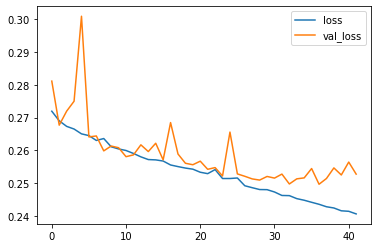

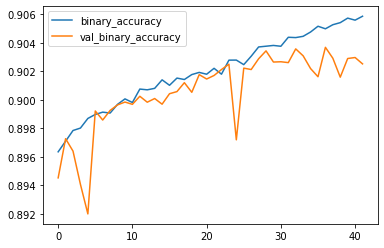

In [62]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [63]:
resnet50_preds = resnet50.predict(test_X, verbose = True)

492/492 [==============================] - 58s 117ms/step


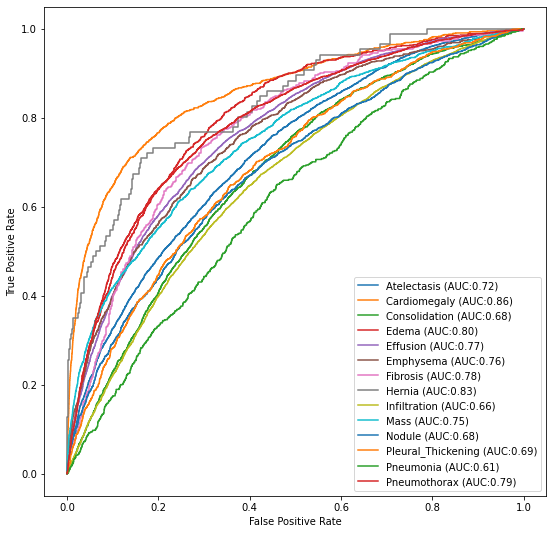

In [64]:
resnet50_AUC = plot_ROC(labels, test_Y, resnet50_preds, filename="augmented_resnet50_ROC.png")

## Mobilenet 

### Using original images

In [65]:
idg = ImageDataGenerator(samplewise_center=True, 
                         samplewise_std_normalization=True)

# Setting up iterators for each subset

train_iter = idg.flow_from_dataframe(dataframe=train_df, 
                             directory = IMG_DIR,
                             x_col = 'Image Name',
                            y_col = 'Finding Labels', 
                             class_mode = 'categorical',
                            classes = labels,
                            color_mode = 'grayscale',
                            target_size = IMG_SIZE,
                            batch_size = 32)

valid_iter = idg.flow_from_dataframe(dataframe=valid_df, 
                             directory = IMG_DIR,
                             x_col = 'Image Name',
                            y_col = 'Finding Labels', 
                             class_mode = 'categorical',
                            classes = labels,
                            color_mode = 'grayscale',
                            target_size = IMG_SIZE,
                            batch_size = 32)

test_iter = idg.flow_from_dataframe(dataframe=test_df, 
                             directory = IMG_DIR,
                             x_col = 'Image Name',
                            y_col = 'Finding Labels', 
                             class_mode = 'categorical',
                            classes = labels,
                            color_mode = 'grayscale',
                            target_size = IMG_SIZE,
                            batch_size = 15735)

# Get next batches
train_X, train_Y = train_iter.next()
valid_X, valid_Y = valid_iter.next()
test_X, test_Y = test_iter.next()

print('Batches train=%d, validation=%d, test=%d' % (len(train_iter), len(valid_iter),len(test_iter)))
print('Batch X shape=%s, min=%.3f, max=%.3f' % (train_X.shape, train_X.min(), train_X.max()))
print('Batch Y shape=%s, min=%.3f, max=%.3f' % (train_Y.shape, train_Y.min(), train_Y.max()))

Found 28819 validated image filenames belonging to 14 classes.
Found 7205 validated image filenames belonging to 14 classes.
Found 15735 validated image filenames belonging to 14 classes.
Batches train=901, validation=226, test=1
Batch X shape=(32, 224, 224, 1), min=-3.537, max=3.629
Batch Y shape=(32, 14), min=0.000, max=1.000


In [66]:
mobilenet_weight_path="mobilenet_best_weights.hdf5"

In [67]:
mobilenet_weight_path="mobilenet_best_weights.hdf5"

optimizer_list = [('adam', optimizers.Adam())]
checkpoint = ModelCheckpoint(filepath=mobilenet_weight_path, monitor = 'val_loss', verbose=1, 
                             save_best_only=True, mode = 'min', save_weights_only = True)

early = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5, restore_best_weights=True)
callbacks_list = [checkpoint, early]

In [70]:
mobilenet = create_mobilenet()
mobilenet.compile(optimizer='adam', loss = 'binary_crossentropy', 
               metrics = ['binary_accuracy', 'mae'])

mobilenet.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 224)               229600    
_________________________________________________________________
dropout_5 (Dropout)          (None, 224)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 14)                3150      
Total params: 3,461,038
Trainable params: 3,439,150
Non-trainable params: 21,888
_______________________________________

In [71]:
history = mobilenet.fit(train_iter, steps_per_epoch=len(train_iter), callbacks = callbacks_list,
                epochs = 50, validation_data = valid_iter)

Epoch 1/50
901/901 [==============================] - 434s 478ms/step - loss: 0.3349 - binary_accuracy: 0.8795 - mae: 0.1768 - val_loss: 0.2823 - val_binary_accuracy: 0.8917 - val_mae: 0.1646

Epoch 00001: val_loss improved from inf to 0.28232, saving model to mobilenet_best_weights.hdf5
Epoch 2/50
901/901 [==============================] - 429s 476ms/step - loss: 0.2863 - binary_accuracy: 0.8932 - mae: 0.1666 - val_loss: 0.2780 - val_binary_accuracy: 0.8958 - val_mae: 0.1618

Epoch 00002: val_loss improved from 0.28232 to 0.27800, saving model to mobilenet_best_weights.hdf5
Epoch 3/50
901/901 [==============================] - 430s 477ms/step - loss: 0.2802 - binary_accuracy: 0.8941 - mae: 0.1638 - val_loss: 0.2708 - val_binary_accuracy: 0.8954 - val_mae: 0.1606

Epoch 00003: val_loss improved from 0.27800 to 0.27082, saving model to mobilenet_best_weights.hdf5
Epoch 4/50
901/901 [==============================] - 429s 476ms/step - loss: 0.2767 - binary_accuracy: 0.8956 - mae: 0.1617 

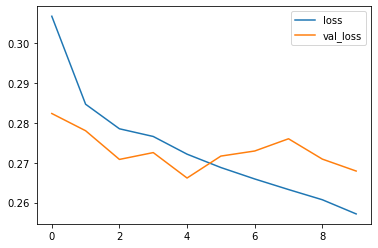

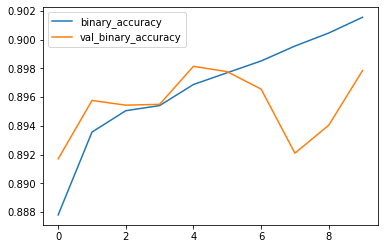

In [72]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [73]:
mobilenet_preds = mobilenet.predict(test_X, verbose = True)

492/492 [==============================] - 22s 43ms/step


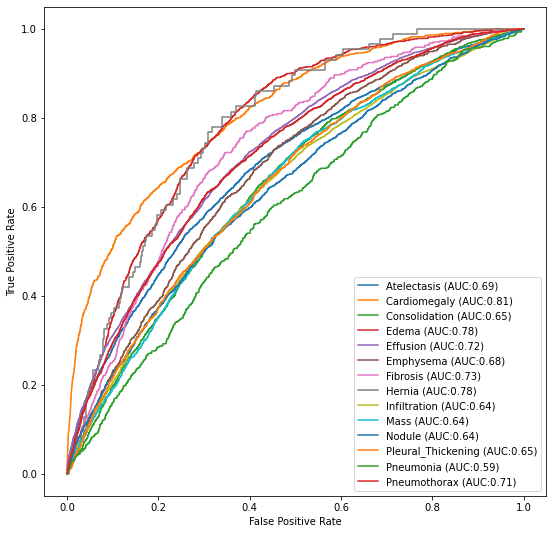

In [74]:
mobilenet_AUC = plot_ROC(labels, test_Y, mobilenet_preds, filename="mobilenet_ROC_not_augmented.png")

### Using augmented images

In [76]:
# Setting up an image data generator
idg = ImageDataGenerator(samplewise_center=True, 
                         samplewise_std_normalization=True,
                         horizontal_flip = True, 
                         vertical_flip = False, 
                         height_shift_range= 0.05, 
                         width_shift_range=0.1, 
                         rotation_range = 5, 
                         fill_mode = 'constant',
                         cval = 0,
                         zoom_range=0.15)

# Setting up iterators for each subset

train_iter = idg.flow_from_dataframe(dataframe=train_df, 
                             directory = IMG_DIR,
                             x_col = 'Image Name',
                            y_col = 'Finding Labels', 
                             class_mode = 'categorical',
                            classes = labels,
                            color_mode = 'grayscale',
                            target_size = IMG_SIZE,
                            batch_size = 32)

valid_iter = idg.flow_from_dataframe(dataframe=valid_df, 
                             directory = IMG_DIR,
                             x_col = 'Image Name',
                            y_col = 'Finding Labels', 
                             class_mode = 'categorical',
                            classes = labels,
                            color_mode = 'grayscale',
                            target_size = IMG_SIZE,
                            batch_size = 32)

test_iter = idg.flow_from_dataframe(dataframe=test_df, 
                             directory = IMG_DIR,
                             x_col = 'Image Name',
                            y_col = 'Finding Labels', 
                             class_mode = 'categorical',
                            classes = labels,
                            color_mode = 'grayscale',
                            target_size = IMG_SIZE,
                            batch_size = 15735)

# Get next batches
train_X, train_Y = train_iter.next()
valid_X, valid_Y = valid_iter.next()
test_X, test_Y = test_iter.next()

print('Batches train=%d, validation=%d, test=%d' % (len(train_iter), len(valid_iter),len(test_iter)))
print('Batch X shape=%s, min=%.3f, max=%.3f' % (train_X.shape, train_X.min(), train_X.max()))
print('Batch Y shape=%s, min=%.3f, max=%.3f' % (train_Y.shape, train_Y.min(), train_Y.max()))

Found 28819 validated image filenames belonging to 14 classes.
Found 7205 validated image filenames belonging to 14 classes.
Found 15735 validated image filenames belonging to 14 classes.
Batches train=901, validation=226, test=1
Batch X shape=(32, 224, 224, 1), min=-3.427, max=2.540
Batch Y shape=(32, 14), min=0.000, max=1.000


In [77]:
history = mobilenet.fit(train_iter, steps_per_epoch=len(train_iter), callbacks = callbacks_list,
                epochs = 50, validation_data = valid_iter)

Epoch 1/50
901/901 [==============================] - 530s 588ms/step - loss: 0.2762 - binary_accuracy: 0.8952 - mae: 0.1615 - val_loss: 0.2848 - val_binary_accuracy: 0.8893 - val_mae: 0.1685

Epoch 00001: val_loss did not improve from 0.26616
Epoch 2/50
901/901 [==============================] - 526s 584ms/step - loss: 0.2721 - binary_accuracy: 0.8969 - mae: 0.1591 - val_loss: 0.2738 - val_binary_accuracy: 0.8962 - val_mae: 0.1499

Epoch 00002: val_loss did not improve from 0.26616
Epoch 3/50
901/901 [==============================] - 526s 584ms/step - loss: 0.2698 - binary_accuracy: 0.8971 - mae: 0.1579 - val_loss: 0.2746 - val_binary_accuracy: 0.8970 - val_mae: 0.1526

Epoch 00003: val_loss did not improve from 0.26616
Epoch 4/50
901/901 [==============================] - 526s 583ms/step - loss: 0.2679 - binary_accuracy: 0.8978 - mae: 0.1567 - val_loss: 0.2667 - val_binary_accuracy: 0.8971 - val_mae: 0.1544

Epoch 00004: val_loss did not improve from 0.26616
Epoch 5/50
901/901 [====

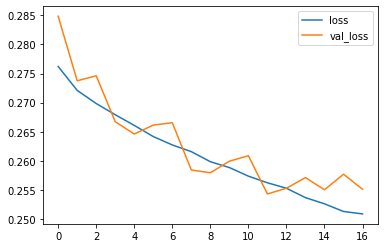

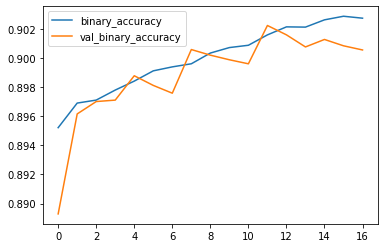

In [78]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [79]:
mobilenet_preds = mobilenet.predict(test_X, verbose = True)

492/492 [==============================] - 21s 43ms/step


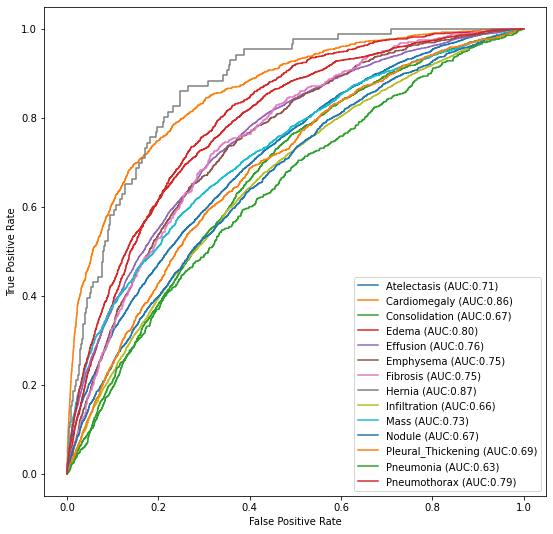

In [80]:
mobilenet_AUC = plot_ROC(labels, test_Y, mobilenet_preds, filename="mobilenet_ROC_not_augmented.png")

## Ensemble of the 2 models

In [81]:
prediction_list = [resnet50_preds, mobilenet_preds]

def max_vote_ensemble(prediction_list):
    ensemble_preds = np.maximum(*prediction_list)
    return ensemble_preds

def hard_vote_ensemble(prediction_list):
    ensemble_preds = np.zeros(prediction_list[0].shape)
    
    for pred in prediction_list:
        ensemble_preds += np.rint(pred)
    
    ensemble_preds /= len(prediction_list)

    return ensemble_preds

def simple_average_ensemble(prediction_list):
    ensemble_preds = np.zeros(prediction_list[0].shape)
    
    for pred in prediction_list:
        ensemble_preds += pred
    
    ensemble_preds /= len(prediction_list)
    
    return ensemble_preds

In [82]:
max_vote_ensemble_preds = max_vote_ensemble(prediction_list)
hard_vote_ensemble_preds = hard_vote_ensemble(prediction_list)
simple_ensemble_preds = simple_average_ensemble(prediction_list)

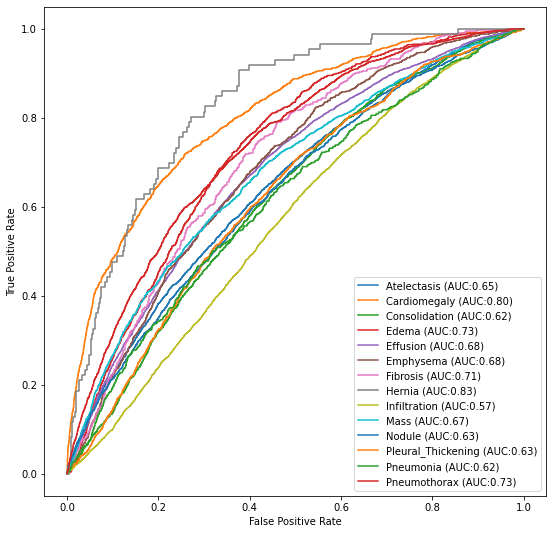

In [84]:
max_vote_ensemble_AUC = plot_ROC(labels, test_Y, max_vote_ensemble_preds, filename="max_vote_ensemble_roc.png")

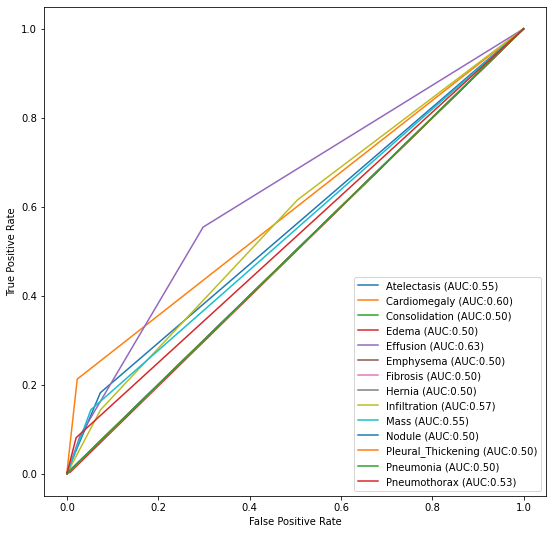

In [85]:
hard_vote_ensemble_AUC = plot_ROC(labels, test_Y, hard_vote_ensemble_preds, filename="hard_vote_ensemble_roc.png")

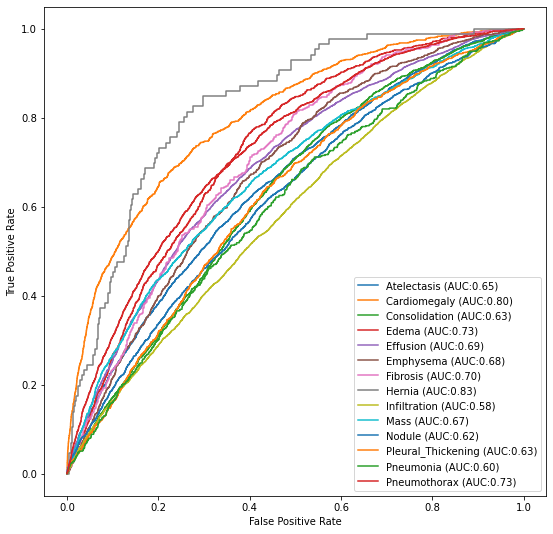

In [86]:
simple_avg_ensemble_AUC = plot_ROC(labels, test_Y, simple_ensemble_preds, filename="simple_ensemble_roc.png")

In [87]:
summary_df = pd.DataFrame(
    {'Class': labels,
     'Resnet50': resnet50_AUC,
     'Mobilenet': mobilenet_AUC,
     'Max Vote Ensemble': max_vote_ensemble_AUC,
     'Hard Vote Ensemble': hard_vote_ensemble_AUC,
     'Avg Ensemble': simple_avg_ensemble_AUC,}
)

In [88]:
summary_df.round(3)

Class  Resnet50  Mobilenet  Max Vote Ensemble  \
0          Atelectasis     0.719      0.710              0.647   
1         Cardiomegaly     0.857      0.859              0.803   
2        Consolidation     0.678      0.669              0.622   
3                Edema     0.802      0.799              0.727   
4             Effusion     0.769      0.757              0.679   
5            Emphysema     0.760      0.748              0.684   
6             Fibrosis     0.775      0.752              0.706   
7               Hernia     0.834      0.871              0.829   
8         Infiltration     0.662      0.659              0.567   
9                 Mass     0.751      0.725              0.674   
10              Nodule     0.683      0.665              0.633   
11  Pleural_Thickening     0.693      0.685              0.626   
12           Pneumonia     0.614      0.634              0.617   
13        Pneumothorax     0.789      0.789              0.735   

    Hard Vote Ensemble  Avg Ensemble  
0                0.555         0.651  
1                0.595         0.802  
2                0.500         0.631  
3                0.498         0.728  
4                0.633         0.691  
5                0.500         0.679  
6                0.500         0.704  
7                0.500         0.829  
8                0.569         0.583  
9                0.546         0.670  
10               0.500         0.619  
11               0.500         0.626  
12               0.500         0.604  
13               0.530         0.731